In [3]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [4]:
import sys

sys.path.append("..")

---

In [5]:
import json
from functools import partial

import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import networkx as nx
from icecream import ic

from funcs.utils import find_project_root

from resources.nlp_models import load_scispacy_lg
from scripts.clean_epigraphdb_ents import clean_text

In [6]:
root = find_project_root()
data_dir = root.parent / "data"
assert data_dir.exists()

ebi_dir = data_dir / "gwas-catalog"
gwas_to_efo_path = ebi_dir / "clean_gwas_to_efo.csv"
assert gwas_to_efo_path.exists()

efo_dir = data_dir / "efo"
efo_graph_file = efo_dir / "efo_graph.gpickle"
assert efo_graph_file.exists()

---

# Encode

In [5]:
nlp = load_scispacy_lg()

2021-06-16 09:25:52.057 | INFO     | funcs.utils:timed:35 - load_scispacy_lg finished in 0.12 mins.


In [6]:
gwas_to_efo = pd.read_csv(gwas_to_efo_path)
print(gwas_to_efo.info())
gwas_to_efo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gwas_name        16871 non-null  object
 1   efo_name         16871 non-null  object
 2   efo_id           16871 non-null  object
 3   parent_efo_name  16871 non-null  object
 4   parent_efo_id    16871 non-null  object
dtypes: object(5)
memory usage: 659.1+ KB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444


In [7]:
def encode(text: str, nlp_model) -> str:
    doc = nlp_model(text)
    if doc.vector is not None:
        return doc.vector.tolist()
    else:
        return []

In [8]:
%%time

gwas_encodes = (
    gwas_to_efo[["gwas_name"]]
    .drop_duplicates()
    .assign(
        clean_text=lambda df: df["gwas_name"].apply(
            lambda x: clean_text(x, nlp_model=nlp)
        )
    )
    .assign(
            vector=lambda df: df["clean_text"].apply(lambda x: encode(x, nlp_model=nlp))
        )
)
print(gwas_encodes.info())
gwas_encodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13334 entries, 0 to 16870
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gwas_name   13334 non-null  object
 1   clean_text  13334 non-null  object
 2   vector      13334 non-null  object
dtypes: object(3)
memory usage: 416.7+ KB
None
CPU times: user 2min 44s, sys: 288 ms, total: 2min 45s
Wall time: 2min 45s


,gwas_name,clean_text,vector
0,Clubfoot,clubfoot,"[-0.37584900856018066, 0.19428400695323944, -0..."
1,Alcohol dependence or heroin dependence or met...,alcohol dependence or heroin dependence or met...,"[-0.11215012520551682, -0.17538602650165558, 0..."
2,Methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,Hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,Age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."


In [9]:
output_file = ebi_dir / "gwas_encodes.csv.gz"
gwas_encodes.to_csv(output_file, index=False, compression="gzip")

In [10]:
%%time

efo_encodes = (
    gwas_to_efo[["efo_id", "efo_name"]]
    .drop_duplicates()
    .assign(
        clean_text=lambda df: df["efo_name"].apply(
            lambda x: clean_text(x, nlp_model=nlp)
        )
    )
    .assign(
            vector=lambda df: df["clean_text"].apply(lambda x: encode(x, nlp_model=nlp))
        )
)
print(efo_encodes.info())
efo_encodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 16869
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   efo_id      2761 non-null   object
 1   efo_name    2761 non-null   object
 2   clean_text  2761 non-null   object
 3   vector      2761 non-null   object
dtypes: object(4)
memory usage: 107.9+ KB
None
CPU times: user 31 s, sys: 72 ms, total: 31.1 s
Wall time: 31.1 s


,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
9,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."


In [11]:
output_file = ebi_dir / "efo_encodes.csv.gz"
efo_encodes.to_csv(output_file, index=False, compression="gzip")

---

# similarity score

In [12]:
gwas_arr = np.stack(np.array(gwas_encodes["vector"].tolist()), axis=0)
print(gwas_arr.shape)
assert gwas_arr[0, :].tolist() == gwas_encodes["vector"][0]

(13334, 200)


In [13]:
efo_arr = np.stack(np.array(efo_encodes["vector"].tolist()), axis=0)
print(efo_arr.shape)
assert efo_arr[0, :].tolist() == efo_encodes["vector"][0]

(2761, 200)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine as cosine_distance

In [15]:
%%time

similarity_arr = cosine_similarity(gwas_arr, efo_arr)
print(similarity_arr.shape)

(13334, 2761)
CPU times: user 9.34 s, sys: 28.1 s, total: 37.5 s
Wall time: 1.01 s


In [16]:
print(similarity_arr[0, 0])
print(1 - cosine_distance(gwas_encodes["vector"][0], efo_encodes["vector"][0],))

0.5734677237334654
0.5734677237334653


In [17]:
output_file = ebi_dir / "similarity_arr.npy"
np.save(output_file, similarity_arr)

---

# analysis

In [7]:
gwas_encodes_path = ebi_dir / "gwas_encodes.csv.gz"
efo_encodes_path = ebi_dir / "efo_encodes.csv.gz"
gwas_to_efo_path = ebi_dir / "clean_gwas_to_efo.csv"
similarity_arr_path = ebi_dir / "similarity_arr.npy"

In [8]:
gwas_to_efo = pd.read_csv(gwas_to_efo_path)
print(gwas_to_efo.info())
gwas_to_efo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gwas_name        16871 non-null  object
 1   efo_name         16871 non-null  object
 2   efo_id           16871 non-null  object
 3   parent_efo_name  16871 non-null  object
 4   parent_efo_id    16871 non-null  object
dtypes: object(5)
memory usage: 659.1+ KB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444


In [9]:
gwas_encodes = pd.read_csv(gwas_encodes_path).assign(
    vector=lambda df: df["vector"].apply(json.loads)
)
print(gwas_encodes.info())
gwas_encodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13334 entries, 0 to 13333
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gwas_name   13334 non-null  object
 1   clean_text  13334 non-null  object
 2   vector      13334 non-null  object
dtypes: object(3)
memory usage: 312.6+ KB
None


,gwas_name,clean_text,vector
0,Clubfoot,clubfoot,"[-0.37584900856018066, 0.19428400695323944, -0..."
1,Alcohol dependence or heroin dependence or met...,alcohol dependence or heroin dependence or met...,"[-0.11215012520551682, -0.17538602650165558, 0..."
2,Methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,Hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,Age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."


In [10]:
efo_encodes = pd.read_csv(efo_encodes_path).assign(
    vector=lambda df: df["vector"].apply(json.loads)
)
print(efo_encodes.info())
efo_encodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   efo_id      2761 non-null   object
 1   efo_name    2761 non-null   object
 2   clean_text  2761 non-null   object
 3   vector      2761 non-null   object
dtypes: object(4)
memory usage: 86.4+ KB
None


,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
2,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
3,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
4,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."


In [11]:
similarity_arr = np.load(similarity_arr_path)

In [12]:
similarity_arr.shape

(13334, 2761)

In [13]:
print(similarity_arr)

[[ 0.57346772 -0.08321398  0.43528596 ...  0.14525737  0.25932941
   0.06446416]
 [ 0.15219263  0.92250771  0.10776712 ...  0.02089715 -0.01034494
   0.15754692]
 [ 0.00778261  1.          0.08975805 ...  0.03561883 -0.03105269
   0.16007295]
 ...
 [ 0.11294115  0.07792424  0.21593123 ... -0.00859792 -0.07831833
   0.03265154]
 [ 0.24552335  0.11146804  0.31138856 ...  0.15902792  0.08289844
   0.16645138]
 [ 0.19952689  0.18990634  0.14023943 ...  0.1246996  -0.02603151
   0.82895111]]


In [14]:
def get_rank(gwas_idx, efo_idx, similarity_arr):
    arr = similarity_arr[gwas_idx, :]
    order = arr.argsort()
    ranks = order.argsort()
    # inverse rank largest to smallest
    efo_idx_rank = len(arr) - ranks[efo_idx]
    return efo_idx_rank

In [15]:
efo_idx_df = efo_encodes[["efo_id"]].reset_index(drop=False).set_index("efo_id")
gwas_idx_df = gwas_encodes[["gwas_name"]].reset_index(drop=False).set_index("gwas_name")
gwas_to_efo = (
    gwas_to_efo.assign(
        efo_idx=lambda df: df["efo_id"].apply(lambda x: efo_idx_df.at[x, "index"]),
        gwas_idx=lambda df: df["gwas_name"].apply(lambda x: gwas_idx_df.at[x, "index"]),
    )
    .assign(
        expected_match_rank=lambda df: df.apply(
            lambda row: get_rank(
                gwas_idx=row["gwas_idx"],
                efo_idx=row["efo_idx"],
                similarity_arr=similarity_arr,
            ),
            axis=1,
        )
    )
    .assign(
        expected_match_rank_bin=lambda df: pd.cut(
            df["expected_match_rank"], bins=[0, 5, 10, 20, float("inf")]
        )
    )
)
gwas_to_efo

,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id,efo_idx,gwas_idx,expected_match_rank,expected_match_rank_bin
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,0,0,7,"(5.0, 10.0]"
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,1,5,"(0.0, 5.0]"
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,2,1,"(0.0, 5.0]"
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,2,3,1,"(0.0, 5.0]"
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,3,4,1,"(0.0, 5.0]"
...,...,...,...,...,...,...,...,...,...
16866,Moderate or severe prolonged lymphopenia in di...,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Immune system disorder,http://www.ebi.ac.uk/efo/EFO_0000540,2758,2076,1,"(0.0, 5.0]"
16867,Severe prolonged lymphopenia in dimethyl fumar...,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Immune system disorder,http://www.ebi.ac.uk/efo/EFO_0000540,2758,2077,1,"(0.0, 5.0]"
16868,Surgical necrotising enterocolitis in extremel...,necrotizing enterocolitis,http://www.ebi.ac.uk/efo/EFO_0003928,Digestive system disorder,http://www.ebi.ac.uk/efo/EFO_0000405,2759,13301,4,"(0.0, 5.0]"
16869,Cognitive performance,neuropsychological test,http://www.ebi.ac.uk/efo/EFO_0003926,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,2760,6065,29,"(20.0, inf]"


## analysis: distribution of ranks of the expected match

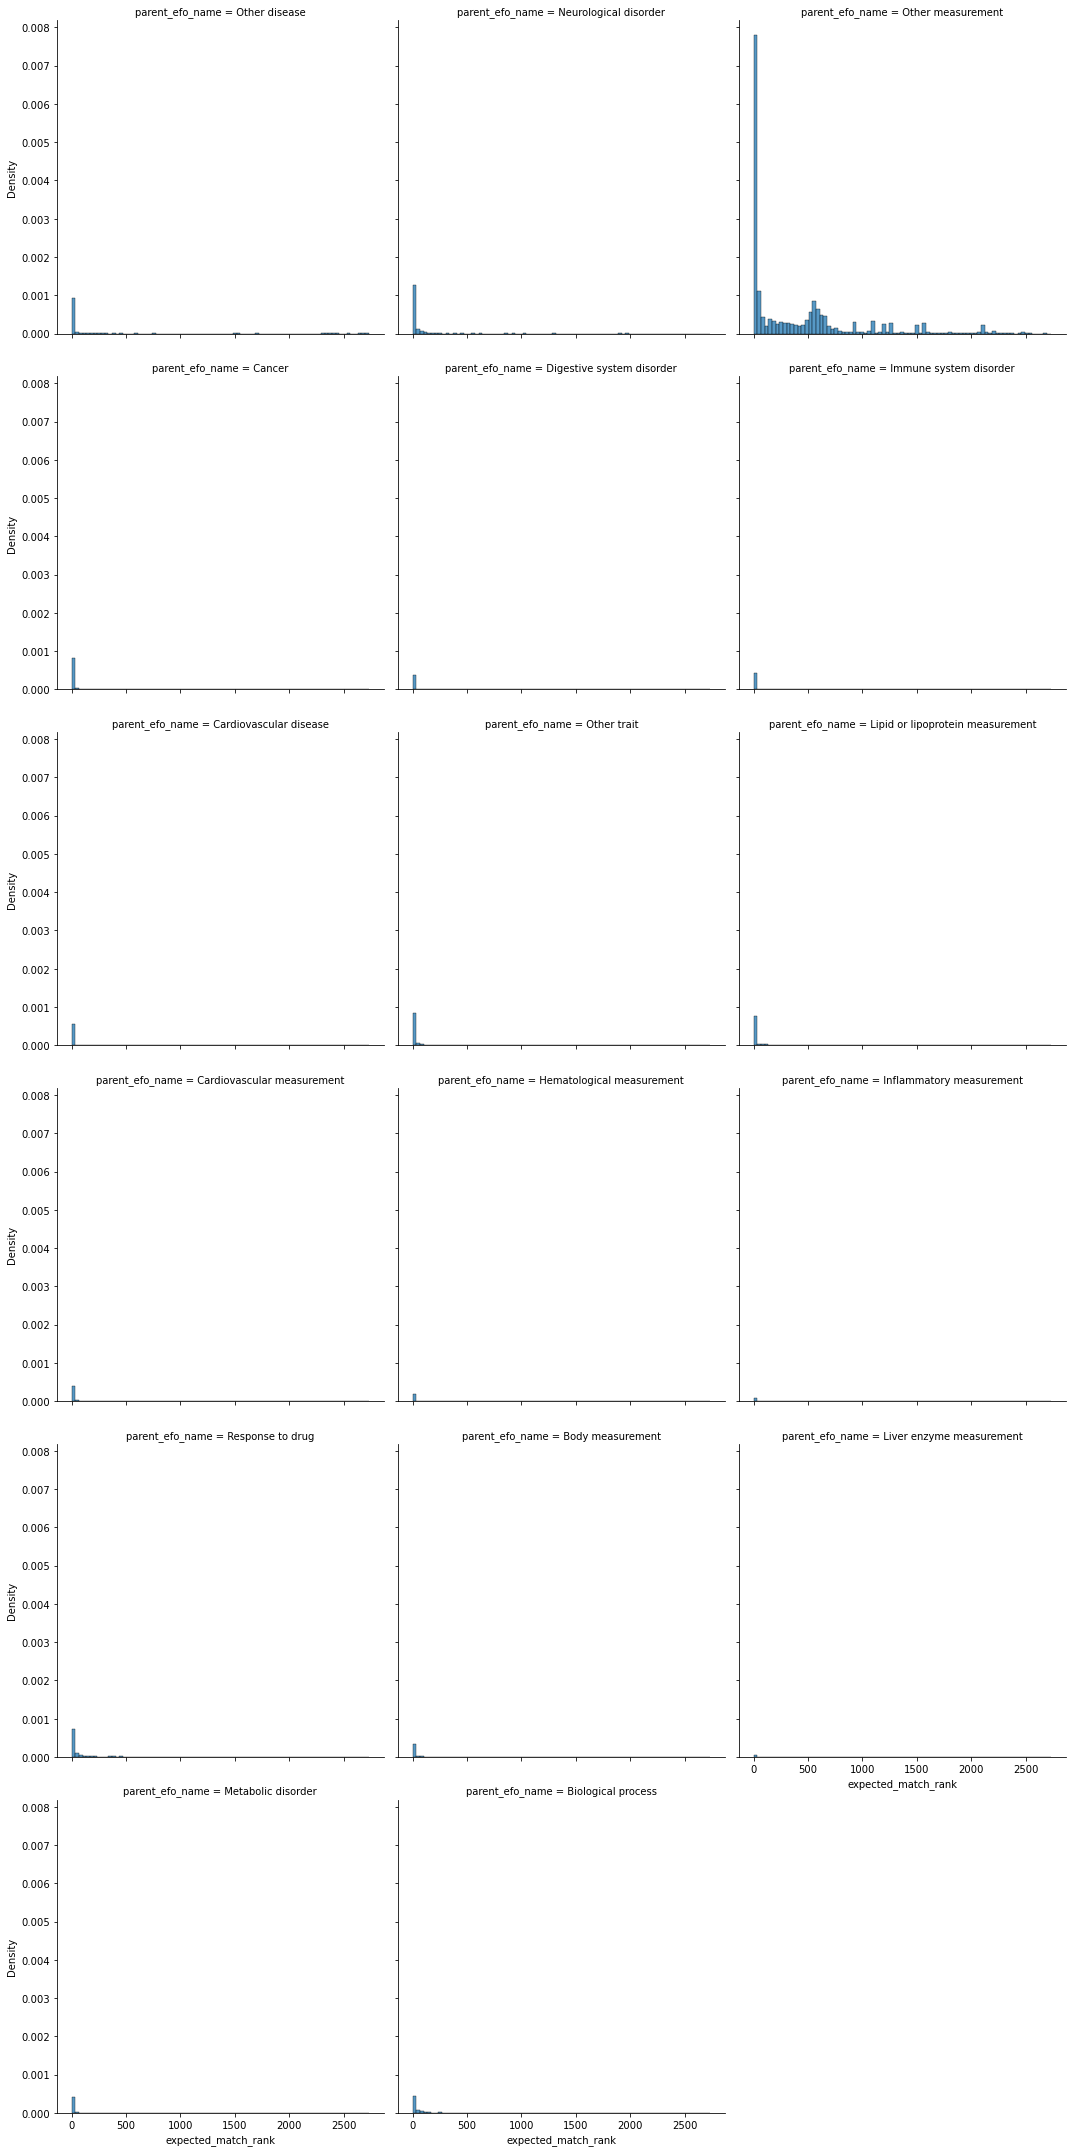

In [16]:
sns.displot(
    data=gwas_to_efo,
    x="expected_match_rank",
    col="parent_efo_name",
    col_wrap=3,
    kind="hist",
    stat="density",
)

In [17]:
s = gwas_to_efo[gwas_to_efo["parent_efo_name"] == "Cancer"]["expected_match_rank"]
print(len(s))
s.value_counts()

510


1      210
2       58
3       26
7       21
4       17
      ... 
48       1
43       1
464      1
40       1
512      1
Name: expected_match_rank, Length: 71, dtype: int64

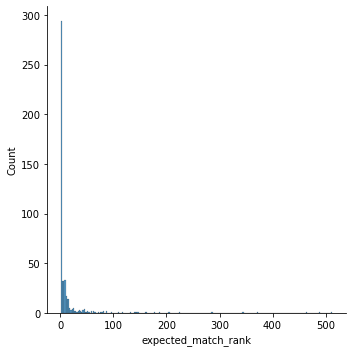

In [18]:
ax = sns.displot(s)

In [19]:
df = (
    gwas_to_efo[["parent_efo_name", "expected_match_rank_bin"]]
    .groupby("parent_efo_name")["expected_match_rank_bin"]
    .value_counts(normalize=True)
    .rename("percent")
    .to_frame()
    .reset_index()
)
df

,parent_efo_name,expected_match_rank_bin,percent
0,Biological process,"(20.0, inf]",0.439086
1,Biological process,"(0.0, 5.0]",0.431472
2,Biological process,"(10.0, 20.0]",0.071066
3,Biological process,"(5.0, 10.0]",0.058376
4,Body measurement,"(0.0, 5.0]",0.611765
...,...,...,...
62,Other trait,"(10.0, 20.0]",0.048561
63,Response to drug,"(20.0, inf]",0.409861
64,Response to drug,"(0.0, 5.0]",0.399076
65,Response to drug,"(10.0, 20.0]",0.100154


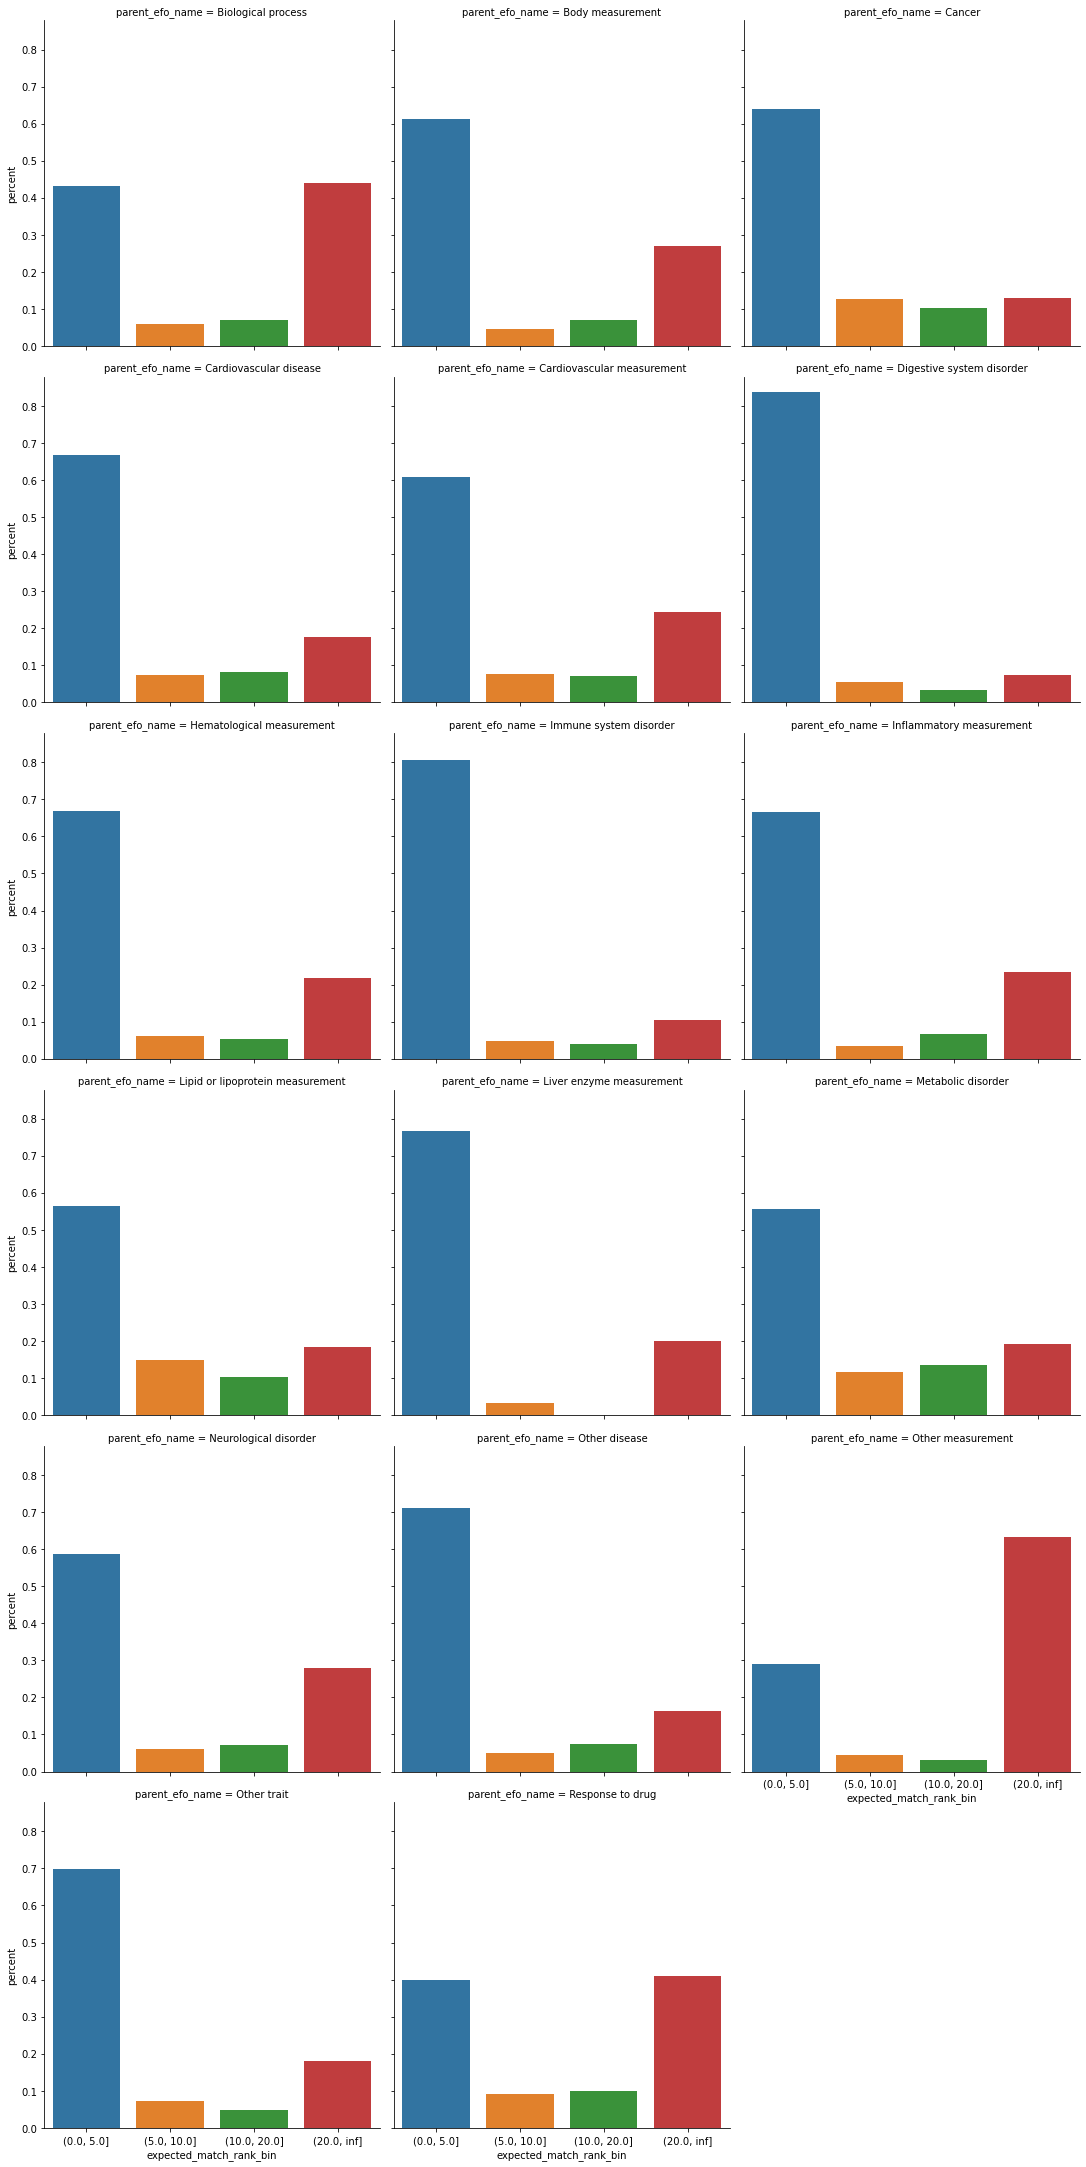

In [20]:
sns.catplot(
    x="expected_match_rank_bin",
    y="percent",
    col="parent_efo_name",
    col_wrap=3,
    data=df,
    kind="bar",
)

# percentage of expected match falling to top rank groups

In [21]:
def top_x(s, cutoff):
    return sum(s.apply(lambda x: x <= cutoff)) / len(s) * 100


top_ranks = (
    gwas_to_efo[["parent_efo_name", "expected_match_rank"]]
    .groupby("parent_efo_name")
    .agg(
        first_3=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=3),
        ),
        first_5=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=5),
        ),
        first_10=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=10),
        ),
        first_15=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=15),
        ),
        first_20=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=20),
        ),
    )
)
top_ranks

,first_3,first_5,first_10,first_15,first_20
parent_efo_name,,,,,
Biological process,37.309645,43.147208,48.984772,52.538071,56.091371
Body measurement,58.431373,61.176471,65.882353,69.411765,72.941176
Cancer,57.647059,63.921569,76.666667,84.509804,87.058824
Cardiovascular disease,62.889518,66.855524,74.220963,79.603399,82.436261
Cardiovascular measurement,53.169014,60.915493,68.661972,72.887324,75.704225
Digestive system disorder,77.570093,83.644860,89.252336,91.121495,92.523364
Hematological measurement,60.150376,66.917293,72.932331,75.939850,78.195489
Immune system disorder,73.408240,80.524345,85.393258,88.014981,89.513109
Inflammatory measurement,58.333333,66.666667,70.000000,73.333333,76.666667


## analysis: 'wrong' matches

In [33]:
efo_encodes

,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
2,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
3,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
4,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."
...,...,...,...,...
2756,http://purl.obolibrary.org/obo/GO_1902521,response to etoposide,response to etoposide,"[-0.11071803420782089, 0.10049143433570862, 0...."
2757,http://purl.obolibrary.org/obo/HP_0011141,age-related cataract,age-related cataract,"[-0.21213899552822113, -0.061980895698070526, ..."
2758,http://www.ebi.ac.uk/efo/EFO_0003929,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,"[-0.23882098495960236, 0.4487026631832123, 0.1..."
2759,http://www.ebi.ac.uk/efo/EFO_0003928,necrotizing enterocolitis,necrotize enterocolitis,"[0.15296250581741333, 0.13960769772529602, -0...."


In [34]:
efo_idx_df

,index
efo_id,
http://www.orpha.net/ORDO/Orphanet_199315,0
http://www.ebi.ac.uk/efo/EFO_0004701,1
http://www.ebi.ac.uk/efo/EFO_0004705,2
http://www.ebi.ac.uk/efo/EFO_0004704,3
http://www.ebi.ac.uk/efo/EFO_0004703,4
...,...
http://purl.obolibrary.org/obo/GO_1902521,2756
http://purl.obolibrary.org/obo/HP_0011141,2757
http://www.ebi.ac.uk/efo/EFO_0003929,2758


In [35]:
arr = np.array([6, 1, 3, 2, 5])
print(arr)
flip_arr = -arr
print(flip_arr)
order = flip_arr.argsort()
print(order)
ranks = order.argsort()
print(ranks)
n = 3
top_n_idx = order[:n]
print(top_n_idx)
top_n_value = arr[top_n_idx]
print(top_n_value)

[6 1 3 2 5]
[-6 -1 -3 -2 -5]
[0 4 2 3 1]
[0 4 2 3 1]
[0 4 2]
[6 5 3]


In [36]:
def get_top_matches(gwas_idx, similarity_arr, efo_idx_df, efo_encodes, top_n=10):
    # ic(gwas_encodes["gwas_name"][gwas_idx])
    arr = similarity_arr[gwas_idx, :]
    # ic(arr)
    flip_arr = -arr
    # ic(flip_arr)
    order = flip_arr.argsort()
    # ic(order)
    ranks = order.argsort()
    # ic(ranks)
    top_ranking_idx = order[:top_n].tolist()
    # ic(top_ranking_idx)
    # ic(arr[top_ranking_idx])
    # ic(arr[0])
    top_ranking_labels = efo_encodes["efo_name"][top_ranking_idx].tolist()
    res = top_ranking_labels
    return res


get_top_matches(0, similarity_arr, efo_idx_df, efo_encodes)

['scoliosis',
 'hallux valgus',
 'adolescent idiopathic scoliosis',
 'hypospadias',
 'esotropia',
 'Non-accomodative esotropia',
 'familial clubfoot with or without associated lower limb anomalies',
 'metopic craniosynostosis',
 'Hemifacial microsomia',
 'strabismus']

### expected matches rank above 100

In [37]:
df = gwas_to_efo[gwas_to_efo["expected_match_rank"] > 100]
df = df.assign(
    top_matches=lambda df: df["gwas_idx"].apply(
        lambda x: get_top_matches(x, similarity_arr, efo_idx_df, efo_encodes)
    )
)

In [38]:
for idx, row in df.groupby("parent_efo_name").head(4).reset_index(drop=True).iterrows():
    print("{group} #{idx}".format(group=row["parent_efo_name"], idx=idx))
    print(row["gwas_name"], "\t", row["efo_name"], "\t", row["parent_efo_name"])
    print(row["top_matches"])
    print("\n")

Other measurement #0
Aging traits 	 age at menopause 	 Other measurement
['complex trait', 'personality trait', 'personality trait measurement', 'longevity', 'genetic variation', 'parental longevity', 'behavior or behavioral disorder measurement', 'outer ear morphology trait', 'psychological resilience measurement', 'psychosis predisposition measurement']


Other measurement #1
Lung function (FEV1/FVC) 	 FEV/FEC ratio 	 Other measurement
['small cell lung carcinoma', 'kidney injury molecule 1 measurement', 'pulmonary function measurement', 'lung disease associated with cystic fibrosis', 'thyroid function', 'anemia (phenotype)', 'rapid kidney function decline', 'lung adenocarcinoma', 'interstitial lung disease', 'lung carcinoma']


Other measurement #2
Lung function (FEV1/FVC) in asthma 	 FEV/FEC ratio 	 Other measurement
['lung disease associated with cystic fibrosis', 'asthma', 'asthma exacerbation measurement', 'lung disease severity measurement', 'family history of lung cancer', 'in

### expected matches rank [10, 20]

In [29]:
df = gwas_to_efo[
    (gwas_to_efo["expected_match_rank"] >= 10)
    & (gwas_to_efo["expected_match_rank"] <= 20)
]
df = df.assign(
    top_matches=lambda df: df["gwas_idx"].apply(
        lambda x: get_top_matches(x, similarity_arr, efo_idx_df, efo_encodes)
    )
)

In [39]:
for idx, row in df.groupby("parent_efo_name").head(4).reset_index(drop=True).iterrows():
    print("{group} #{idx}".format(group=row["parent_efo_name"], idx=idx))
    print(row["gwas_name"], "\t", row["efo_name"], "\t", row["parent_efo_name"])
    print(row["top_matches"])
    print("\n")

Other measurement #0
Aging traits 	 age at menopause 	 Other measurement
['complex trait', 'personality trait', 'personality trait measurement', 'longevity', 'genetic variation', 'parental longevity', 'behavior or behavioral disorder measurement', 'outer ear morphology trait', 'psychological resilience measurement', 'psychosis predisposition measurement']


Other measurement #1
Lung function (FEV1/FVC) 	 FEV/FEC ratio 	 Other measurement
['small cell lung carcinoma', 'kidney injury molecule 1 measurement', 'pulmonary function measurement', 'lung disease associated with cystic fibrosis', 'thyroid function', 'anemia (phenotype)', 'rapid kidney function decline', 'lung adenocarcinoma', 'interstitial lung disease', 'lung carcinoma']


Other measurement #2
Lung function (FEV1/FVC) in asthma 	 FEV/FEC ratio 	 Other measurement
['lung disease associated with cystic fibrosis', 'asthma', 'asthma exacerbation measurement', 'lung disease severity measurement', 'family history of lung cancer', 'in

## analysis: distances of top ranking terms to expected match term

In [40]:
efo_graph = nx.read_gpickle(efo_graph_file)
efo_graph

In [41]:
undirected_graph = efo_graph.to_undirected()

In [42]:
gwas_name = "Body mass index"
gwas_idx = gwas_encodes["gwas_name"][
    gwas_encodes["gwas_name"] == gwas_name
].index.tolist()[0]
ic(gwas_idx)

expected_efo_name = "body mass index"
expected_id_row = efo_encodes["efo_id"][efo_encodes["efo_name"] == expected_efo_name]
ic(expected_id_row)
expected_idx = expected_id_row.index.tolist()[0]
ic(expected_idx)
expected_id = expected_id_row.tolist()[0]
ic(expected_id)

ic| gwas_idx: 2319
ic| expected_id_row: 1680    http://www.ebi.ac.uk/efo/EFO_0004340
                     Name: efo_id, dtype: object
ic| expected_idx: 1680
ic| expected_id: 'http://www.ebi.ac.uk/efo/EFO_0004340'


'http://www.ebi.ac.uk/efo/EFO_0004340'

In [43]:
def get_top_matches_ids(gwas_idx, similarity_arr, efo_idx_df, efo_encodes, top_n=10):
    arr = similarity_arr[gwas_idx, :]
    flip_arr = -arr
    order = flip_arr.argsort()
    ranks = order.argsort()
    top_ranking_idx = order[:top_n].tolist()
    top_ranking_ids = efo_encodes["efo_id"][top_ranking_idx].tolist()
    res = top_ranking_ids
    return res


top_names = get_top_matches(gwas_idx, similarity_arr, efo_idx_df, efo_encodes)
ic(top_names)
top_ids = get_top_matches_ids(gwas_idx, similarity_arr, efo_idx_df, efo_encodes)
ic(top_ids)

ic| top_names: ['body mass index',
                'height-adjusted body mass index',
                'obese body mass index status',
                'overweight body mass index status',
                'lean body mass',
                'fat body mass',
                'underweight body mass index status',
                'lean mass-adjusted fat body mass',
                'body height',
                'body weight']
ic| top_ids: ['http://www.ebi.ac.uk/efo/EFO_0004340',
              'http://www.ebi.ac.uk/efo/EFO_0005851',
              'http://www.ebi.ac.uk/efo/EFO_0007041',
              'http://www.ebi.ac.uk/efo/EFO_0005935',
              'http://www.ebi.ac.uk/efo/EFO_0004995',
              'http://www.ebi.ac.uk/efo/EFO_0005409',
              'http://www.ebi.ac.uk/efo/EFO_0005936',
              'http://www.ebi.ac.uk/efo/EFO_0009890',
              'http://www.ebi.ac.uk/efo/EFO_0004339',
              'http://www.ebi.ac.uk/efo/EFO_0004338']


['http://www.ebi.ac.uk/efo/EFO_0004340',
 'http://www.ebi.ac.uk/efo/EFO_0005851',
 'http://www.ebi.ac.uk/efo/EFO_0007041',
 'http://www.ebi.ac.uk/efo/EFO_0005935',
 'http://www.ebi.ac.uk/efo/EFO_0004995',
 'http://www.ebi.ac.uk/efo/EFO_0005409',
 'http://www.ebi.ac.uk/efo/EFO_0005936',
 'http://www.ebi.ac.uk/efo/EFO_0009890',
 'http://www.ebi.ac.uk/efo/EFO_0004339',
 'http://www.ebi.ac.uk/efo/EFO_0004338']

In [44]:
top_match_steps = [
    nx.shortest_path_length(undirected_graph, _, expected_efo_name)
    for _ in top_names
    if _ in list(undirected_graph.nodes)
]
ic(top_match_steps)

weighted_steps = sum(
    ((len(top_match_steps) - idx) / np.sum(np.arange(1, len(top_match_steps) + 1))) * _
    for idx, _ in enumerate(top_match_steps)
)
ic(weighted_steps)

ic| top_match_steps: [0, 1, 1, 1, 3, 3, 1, 4, 2, 2]
ic| weighted_steps: 1.4363636363636365


1.4363636363636365

In [45]:
%%time

def calc_weighted_steps(row_data, undirected_graph, efo_nodes):
    expected_efo_name = row_data["efo_name"]
    if expected_efo_name not in efo_nodes:
        return np.nan
    top_matches = row_data["top_matches"]
    top_steps = [
        nx.shortest_path_length(undirected_graph, _, expected_efo_name)
        for _ in top_matches
        if _ in efo_nodes
    ]
    denom = np.sum(np.arange(1, len(top_steps) + 1))
    weighted_steps = sum(
        [((len(top_steps) - idx) / denom) * _ for idx, _ in enumerate(top_steps)]
    )
    return weighted_steps


efo_nodes = list(undirected_graph.nodes)

steps_df = gwas_to_efo.assign(
    top_matches=lambda df: df["gwas_idx"].apply(
        lambda x: get_top_matches(x, similarity_arr, efo_idx_df, efo_encodes, top_n=5)
    )
).assign(
    weighted_steps=lambda df: df.apply(
        func=lambda row_data: calc_weighted_steps(
            row_data, undirected_graph=undirected_graph, efo_nodes=efo_nodes
        ),
        axis=1,
    )
)
print(steps_df.info())
steps_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   gwas_name                16871 non-null  object  
 1   efo_name                 16871 non-null  object  
 2   efo_id                   16871 non-null  object  
 3   parent_efo_name          16871 non-null  object  
 4   parent_efo_id            16871 non-null  object  
 5   efo_idx                  16871 non-null  int64   
 6   gwas_idx                 16871 non-null  int64   
 7   expected_match_rank      16871 non-null  int64   
 8   expected_match_rank_bin  16871 non-null  category
 9   top_matches              16871 non-null  object  
 10  weighted_steps           16363 non-null  float64 
dtypes: category(1), float64(1), int64(3), object(6)
memory usage: 1.3+ MB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id,efo_idx,gwas_idx,expected_match_rank,expected_match_rank_bin,top_matches,weighted_steps
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,0,0,7,"(5.0, 10.0]","[scoliosis, hallux valgus, adolescent idiopath...",NaN
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,1,5,"(0.0, 5.0]","[heroin dependence, cocaine dependence, cannab...",2.200000
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,2,1,"(0.0, 5.0]","[methamphetamine dependence, cocaine dependenc...",1.533333
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,2,3,1,"(0.0, 5.0]","[hypothyroidism, hyperthyroidism, amenorrhea, ...",2.500000
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,3,4,1,"(0.0, 5.0]","[age at menopause, age at menarche, age at ons...",2.000000


In [48]:
steps_df[["parent_efo_name", "weighted_steps"]].groupby("parent_efo_name").describe()

weighted_steps                                \
                                          count      mean       std       min   
parent_efo_name                                                                 
Biological process                        393.0  6.464122  2.514231  0.866667   
Body measurement                          251.0  4.145551  3.353511  0.666667   
Cancer                                    474.0  3.711603  3.068025  0.733333   
Cardiovascular disease                    341.0  4.565298  3.043471  0.900000   
Cardiovascular measurement                273.0  4.494872  2.629932  0.733333   
Digestive system disorder                 211.0  4.074408  2.213656  0.600000   
Hematological measurement                 130.0  3.535385  2.804662  0.733333   
Immune system disorder                    233.0  3.413734  2.461005  0.866667   
Inflammatory measurement                   37.0  3.114414  1.544295  1.466667   
Lipid or lipoprotein measurement          507.0  3.089481  2.412308  0.666667   
Liver enzyme measurement                   30.0  3.297778  2.474993  1.200000   
Metabolic disorder                        156.0  5.017094  3.278715  0.933333   
Neurological disorder                     837.0  5.425687  3.261478  0.733333   
Other disease                             551.0  5.126013  3.157695  0.000000   
Other measurement                       10861.0  4.135792  2.245153  0.600000   
Other trait                               445.0  6.217603  2.538004  0.333333   
Response to drug                          633.0  6.688784  4.071044  0.933333   

                                                                            
                                       25%       50%        75%        max  
parent_efo_name                                                             
Biological process                4.800000  6.866667   8.400000  11.066667  
Body measurement                  1.700000  2.866667   6.266667  13.933333  
Cancer                            1.708333  2.600000   4.316667  13.800000  
Cardiovascular disease            2.066667  3.466667   6.266667  13.000000  
Cardiovascular measurement        2.600000  4.000000   5.333333  12.000000  
Digestive system disorder         2.400000  3.533333   4.933333  11.400000  
Hematological measurement         1.733333  2.466667   4.333333  12.100000  
Immune system disorder            1.600000  2.400000   4.500000  12.866667  
Inflammatory measurement          2.133333  2.933333   3.533333  10.333333  
Lipid or lipoprotein measurement  1.400000  2.000000   3.800000  12.000000  
Liver enzyme measurement          2.000000  2.000000   4.000000  10.466667  
Metabolic disorder                2.450000  3.800000   7.766667  13.300000  
Neurological disorder             2.866667  4.733333   7.533333  13.733333  
Other disease                     2.600000  4.100000   7.166667  13.866667  
Other measurement                 2.866667  3.733333   4.700000  16.266667  
Other trait                       4.200000  6.000000   8.000000  13.600000  
Response to drug                  2.333333  7.066667  10.333333  14.333333

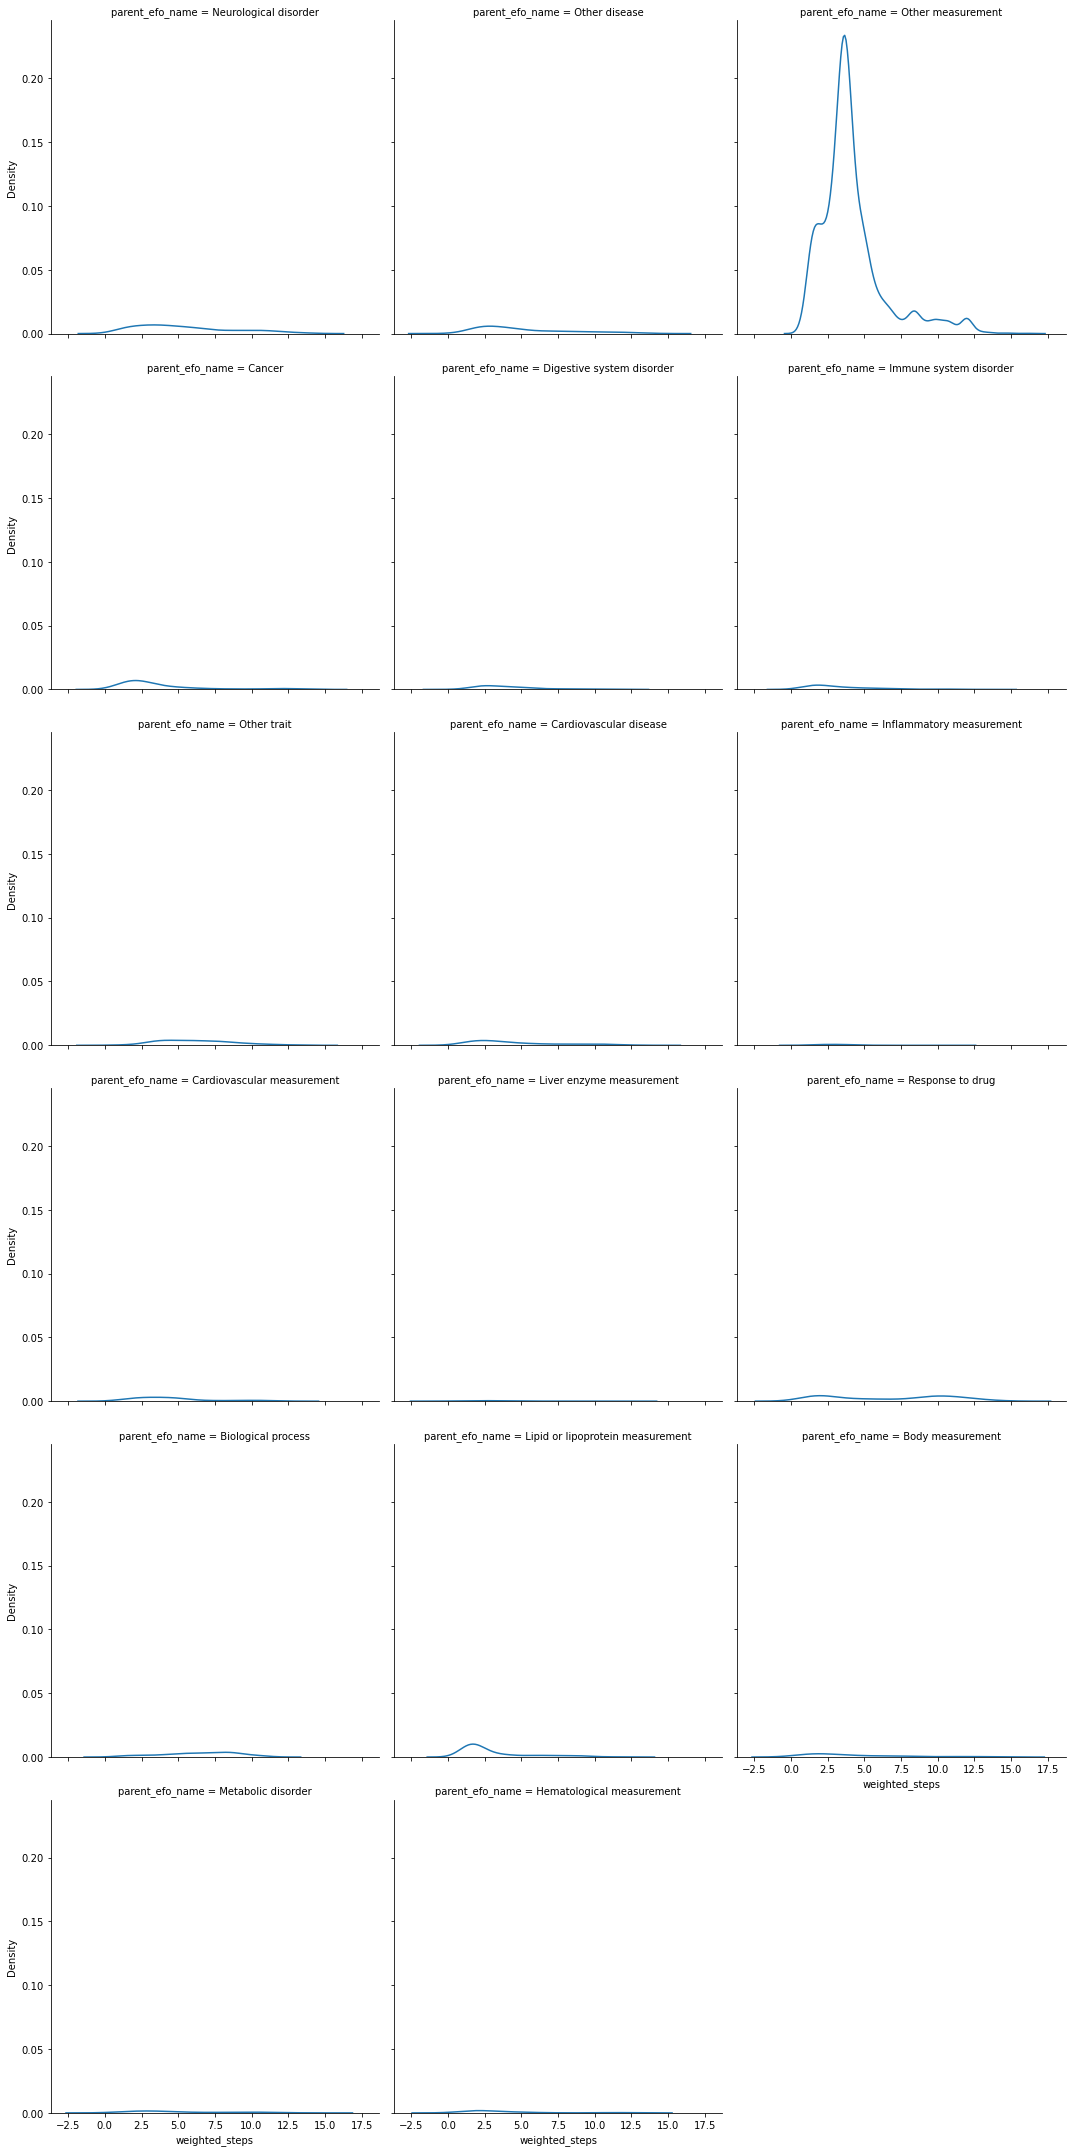

In [49]:
sns.displot(
    data=steps_df.dropna(subset=["weighted_steps"]),
    x="weighted_steps",
    col="parent_efo_name",
    col_wrap=3,
    kind="kde",
)